In [ ]:
!pip install covalent
!pip install PennyLane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.1/272.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

In [ ]:
import covalent as ct
import os
import time

# Set up Covalent server
os.environ["COVALENT_SERVER_IFACE_ANY"] = "1"
os.system("covalent start")
# If you run into any out-of-memory issues with Dask when running this notebook,
# Try reducing the number of workers and making a specific memory request. I.e.:
# os.system("covalent start -m "2GiB" -n 2")
# try covalent –help for more info
time.sleep(2)  # give the Dask cluster some time to launch

In [ ]:
import torch
import scipy.io

# Seed Torch for reproducibility and set default tensor type
GLOBAL_SEED = 1989
torch.manual_seed(GLOBAL_SEED)
torch.set_default_tensor_type(torch.DoubleTensor)

mat = scipy.io.loadmat('features_KW51_sensor6_d0.mat')
X_all = torch.from_numpy(mat['features_data'])
# Shuffle the tensor
indexes = torch.randperm(X_all.shape[0])
X_all = X_all[indexes]

mat_anorm = scipy.io.loadmat('features_KW51_sensor6_d0_2.mat')
Y_all = torch.from_numpy(mat_anorm['features_data'])
indexes = torch.randperm(Y_all.shape[0])
Y_all = Y_all[indexes]

@ct.electron
def generate_normal_time_series_set(
    split_data: int, X_all: float, p: int, num_series: int, noise_amp: float, t_init: float, t_end: float, seed: int = GLOBAL_SEED
) -> tuple:
    """Generate a normal time series data set where each of the p elements
    is drawn from a normal distribution x_t ~ N(0, noise_amp).
    """
    torch.manual_seed(seed)

    if split_data == 1:    #Split data for train
     X=X_all[0:50,:]
    elif split_data == 2:  #Split data for threshold optimization
     X=X_all[0:50,:]
    else:                  #Split data for test
     X=X_all[50:100,:]

    T = torch.linspace(0, 1, 11)
    return X, T


@ct.electron
def generate_anomalous_time_series_set(
    split_data: int,
    Y_all: float,
    p: int,
    num_series: int,
    noise_amp: float,
    spike_amp: float,
    max_duration: int,
    t_init: float,
    t_end: float,
    seed: int = GLOBAL_SEED,
) -> tuple:
    """Generate an anomalous time series data set where the p elements of each sequence are
    from a normal distribution x_t ~ N(0, noise_amp). Then,
    anomalous spikes of random amplitudes and durations are inserted.
    """
    torch.manual_seed(seed)
    if split_data == 1:
     Y=Y_all[0:50,:]
    elif split_data == 2:
     Y=Y_all[0:50,:]
    else:
     Y=Y_all[50:100,:]
    T = torch.linspace(0, 1, 11)
    return Y, T

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


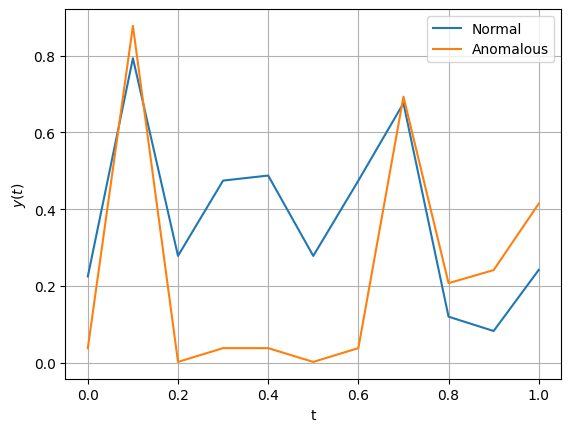

In [ ]:
import matplotlib.pyplot as plt

X_norm, T_norm = generate_normal_time_series_set(1,X_all, 25, 25, 0.1, 0.1, 2 * torch.pi)
Y_anom, T_anom = generate_anomalous_time_series_set(1,Y_all, 25, 25, 0.1, 0.4, 5, 0, 2 * torch.pi)

plt.figure()
plt.plot(T_norm, X_norm[0], label="Normal")
plt.plot(T_anom, Y_anom[0], label="Anomalous")
plt.ylabel("$y(t)$")
plt.xlabel("t")
plt.grid()
leg = plt.legend()

In [ ]:
@ct.electron
def make_atomized_training_set(X: torch.Tensor, T: torch.Tensor) -> list:
    """Convert input time series data provided in a two-dimensional tensor format
    to atomized tuple chunks: (xt, t).
    """
    X_flat = torch.flatten(X)
    T_flat = T.repeat(X.size()[0])
    atomized = [(xt, t) for xt, t in zip(X_flat, T_flat)]
    return atomized

In [ ]:
from collections.abc import Iterator


class DataGetter:
    """A pickleable mock-up of a Python iterator on a torch.utils.Dataloader.
    Provide a dataset X and the resulting object O will allow you to use next(O).
    """

    def __init__(self, X: torch.Tensor, batch_size: int, seed: int = GLOBAL_SEED) -> None:
        """Calls the _init_data method on intialization of a DataGetter object."""
        torch.manual_seed(seed)
        self.X = X
        self.batch_size = batch_size
        self.data = []
        self._init_data(
            iter(torch.utils.data.DataLoader(self.X, batch_size=self.batch_size, shuffle=True))
        )

    def _init_data(self, iterator: Iterator) -> None:
        """Load all of the iterator into a list."""
        x = next(iterator, None)
        while x is not None:
            self.data.append(x)
            x = next(iterator, None)

    def __next__(self) -> tuple:
        """Analogous behaviour to the native Python next() but calling the
        .pop() of the data attribute.
        """
        try:
            return self.data.pop()
        except IndexError:  # Caught when the data set runs out of elements
            self._init_data(
                iter(torch.utils.data.DataLoader(self.X, batch_size=self.batch_size, shuffle=True))
            )
            return self.data.pop()

In [ ]:
@ct.electron
def get_training_cycler(Xtr: torch.Tensor, batch_size: int, seed: int = GLOBAL_SEED) -> DataGetter:
    """Get an instance of the DataGetter class defined above, which behaves analogously to
    next(iterator) but is pickleable.
    """
    return DataGetter(Xtr, batch_size, seed)

In [ ]:
import pennylane as qml
from itertools import combinations


@ct.electron
def D(gamma: torch.Tensor, n_qubits: int, k: int = None, get_probs: bool = False) -> None:
    """Generates an n_qubit quantum circuit according to a k-local Walsh operator
    expansion. Here, k-local means that 1 <= k <= n of the n qubits can interact.
    See <https://doi.org/10.1088/1367-2630/16/3/033040> for more
    details. Optionally return probabilities of bit strings.
    """
    if k is None:
        k = n_qubits
    cnt = 0
    for i in range(1, k + 1):
        for comb in combinations(range(n_qubits), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(n_qubits))

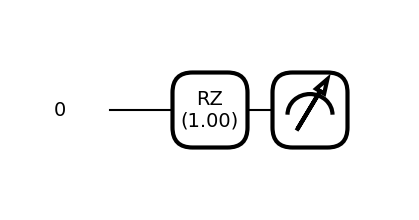

In [ ]:
n_qubits = 1
dev = qml.device("default.qubit", wires=n_qubits, shots=None)
D_one_qubit = qml.qnode(dev)(D)
_ = qml.draw_mpl(D_one_qubit, decimals=2)(torch.tensor([1, 0]), 1, 1, True)

In [ ]:
@ct.electron
@qml.qnode(dev, interface="torch", diff_method="backprop")
def get_probs(
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
) -> torch.Tensor:
    """Measure the probabilities for measuring each bitstring after applying a
    circuit of the form W†DWU to the |0⟩^(⊗n) state. This
    function is defined for individual sequence elements xt.
    """
    U(xt, wires=range(n_qubits))
    W(alpha, wires=range(n_qubits))
    D(gamma * t, n_qubits, k)
    qml.adjoint(W)(alpha, wires=range(n_qubits))
    return qml.probs(range(n_qubits))

In [ ]:
@ct.electron
def get_callable_projector_func(
    k: int, U: callable, W: callable, D: callable, n_qubits: int, probs_func: callable
) -> callable:
    """Using get_probs() above, take only the probability of measuring the
    bitstring of all zeroes (i.e, take the projector
    |0⟩^(⊗n)⟨0|^(⊗n)) on the time devolved state.
    """
    callable_proj = lambda xt, t, alpha, gamma: probs_func(
        xt, t, alpha, gamma, k, U, W, D, n_qubits
    )[0]
    return callable_proj

In [ ]:
@ct.electron
def F(
    callable_proj: callable,
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    mu: torch.Tensor,
    sigma: torch.Tensor,
    gamma_length: int,
    n_samples: int,
) -> torch.Tensor:
    """Take the classical expecation value of of the projector on zero sampling
    the parameters of D from normal distributions. The expecation value is estimated
    with an average over n_samples.
    """
    # length of gamma should not exceed 2^n - 1
    gammas = sigma.abs() * torch.randn((n_samples, gamma_length)) + mu
    expectation = torch.empty(n_samples)
    for i, gamma in enumerate(gammas):
        expectation[i] = callable_proj(xt, t, alpha, gamma)
    return expectation.mean()

In [ ]:
@ct.electron
def callable_arctan_penalty(tau: float) -> callable:
    """Create a callable arctan function with a single hyperparameter
    tau to penalize large entries of sigma.
    """
    prefac = 1 / (torch.pi)
    callable_pen = lambda sigma: prefac * torch.arctan(2 * torch.pi * tau * sigma.abs()).mean()
    return callable_pen

In [ ]:
@ct.electron
def get_loss(
    callable_proj: callable,
    batch: torch.Tensor,
    alpha: torch.Tensor,
    mu: torch.Tensor,
    sigma: torch.Tensor,
    gamma_length: int,
    n_samples: int,
    callable_penalty: callable,
) -> torch.Tensor:
    """Evaluate the loss function ℒ, defined in the background section
    for a certain set of parameters.
    """
    X_batch, T_batch = batch
    loss = torch.empty(X_batch.size()[0])
    for i in range(X_batch.size()[0]):
        # unsqueeze required for tensor to have the correct dimension for PennyLane templates
        loss[i] = (
            1
            - F(
                callable_proj,
                X_batch[i].unsqueeze(0),
                T_batch[i].unsqueeze(0),
                alpha,
                mu,
                sigma,
                gamma_length,
                n_samples,
            )
        ).square()
    return 0.5 * loss.mean() + callable_penalty(sigma)

In [ ]:
@ct.electron
def get_initial_parameters(
    W: callable, W_layers: int, n_qubits: int, seed: int = GLOBAL_SEED
) -> dict:
    """Randomly generate initial parameters. We need initial parameters for the
    variational circuit ansatz implementing W(alpha) and the standard deviation
    and mean (sigma and mu) for the normal distribution we sample gamma from.
    """
    torch.manual_seed(seed)
    init_alpha = torch.rand(W.shape(W_layers, n_qubits))
    init_mu = torch.rand(1)
    # Best to start sigma small and expand if needed
    init_sigma = torch.rand(1)
    init_params = {
        "alpha": (2 * torch.pi * init_alpha).clone().detach().requires_grad_(True),
        "mu": (2 * torch.pi * init_mu).clone().detach().requires_grad_(True),
        "sigma": (0.1 * init_sigma + 0.05).clone().detach().requires_grad_(True),
    }
    return init_params

In [ ]:
@ct.electron
def train_model_gradients(
    lr: float,
    init_params: dict,
    pytorch_optimizer: callable,
    cycler: DataGetter,
    n_samples: int,
    callable_penalty: callable,
    batch_iterations: int,
    callable_proj: callable,
    gamma_length: int,
    seed=GLOBAL_SEED,
    print_intermediate=False,
) -> dict:
    """Train the QVR model (minimize the loss function) with respect to the
    variational parameters using gradient-based training. You need to pass a
    PyTorch optimizer and a learning rate (lr).
    """
    torch.manual_seed(seed)
    opt = pytorch_optimizer(init_params.values(), lr=lr)
    alpha = init_params["alpha"]
    mu = init_params["mu"]
    sigma = init_params["sigma"]

    def closure():
        opt.zero_grad()
        loss = get_loss(
            callable_proj, next(cycler), alpha, mu, sigma, gamma_length, n_samples, callable_penalty
        )
        loss.backward()
        return loss

    loss_history = []
    for i in range(batch_iterations):
        loss = opt.step(closure)
        loss_history.append(loss.item())
        if batch_iterations % 10 == 0 and print_intermediate:
            print(f"Iteration number {i}\n Current loss {loss.item()}\n")

    results_dict = {
        "opt_params": {
            "alpha": opt.param_groups[0]["params"][0],
            "mu": opt.param_groups[0]["params"][1],
            "sigma": opt.param_groups[0]["params"][2],
        },
        "loss_history": loss_history,
    }
    return results_dict

In [ ]:
@ct.lattice
def training_workflow(
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    k: int,
    probs_func: callable,
    W_layers: int,
    gamma_length: int,
    n_samples: int,
    split_data: int,
    X_all: float,
    p: int,
    num_series: int,
    noise_amp: float,
    t_init: float,
    t_end: float,
    batch_size: int,
    tau: float,
    pytorch_optimizer: callable,
    lr: float,
    batch_iterations: int,
):
    """
    Combine all of the previously defined electrons to do an entire training workflow,
    including (1) generating synthetic data, (2) packaging it into training cyclers
    (3) preparing the quantum functions and (4) optimizing the loss function with
    gradient based optimization. You can find definitions for all of the arguments
    by looking at the electrons and text cells above.
    """

    X, T = generate_normal_time_series_set(split_data,X_all, p, num_series, noise_amp, t_init, t_end)
    Xtr = make_atomized_training_set(X, T)
    cycler = get_training_cycler(Xtr, batch_size)
    init_params = get_initial_parameters(W, W_layers, n_qubits)
    callable_penalty = callable_arctan_penalty(tau)
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits, probs_func)
    results_dict = train_model_gradients(
        lr,
        init_params,
        pytorch_optimizer,
        cycler,
        n_samples,
        callable_penalty,
        batch_iterations,
        callable_proj,
        gamma_length,
        print_intermediate=False,
    )
    return results_dict

In [ ]:
general_options = {
    "U": qml.AngleEmbedding,
    "W": qml.StronglyEntanglingLayers,
    "D": D,
    "n_qubits": 1,
    "probs_func": get_probs,
    "gamma_length": 1,
    "n_samples": 10,
    "p": 22,
    "num_series": 25,
    "noise_amp": 0.1,
    "t_init": 0.1,
    "t_end": 2 * torch.pi,
    "k": 1,
}

training_options = {
    "batch_size": 10,
    "tau": 5,
    "split_data": 1, #training data
    "X_all": X_all,
    "pytorch_optimizer": torch.optim.Adam,
    "lr": 0.01,
    "batch_iterations": 1000,
    "W_layers": 2,
}

training_options.update(general_options)

In [ ]:
tr_dispatch_id = ct.dispatch(training_workflow)(**training_options)

In [ ]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(10000)

1000


In [ ]:
ct_tr_results = ct.get_result(dispatch_id=tr_dispatch_id, wait=True)
results_dict = ct_tr_results.result

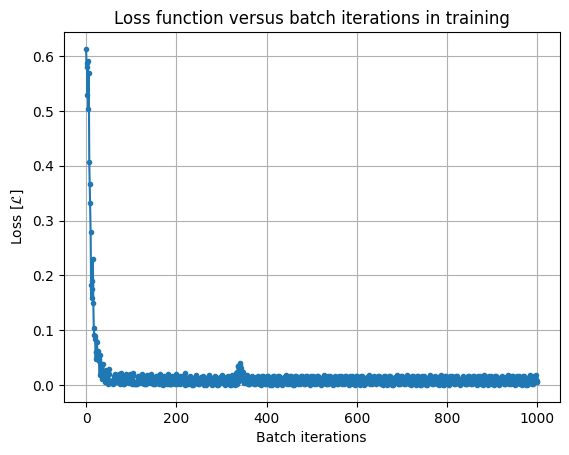

In [ ]:
plt.figure()
plt.plot(results_dict["loss_history"], ".-")
plt.ylabel("Loss [$\mathcal{L}$]")
plt.xlabel("Batch iterations")
plt.title("Loss function versus batch iterations in training")
plt.grid()

In [ ]:
@ct.electron
def get_preds_given_threshold(zeta: float, scores: torch.Tensor) -> torch.Tensor:
    """For a given threshold, get the predicted labels (1 or -1), given the anomaly scores."""
    return torch.tensor([-1 if score > zeta else 1 for score in scores])


@ct.electron
def get_truth_labels(
    normal_series_set: torch.Tensor, anomalous_series_set: torch.Tensor
) -> torch.Tensor:
    """Get a 1D tensor containing the truth values (1 or -1) for a given set of
    time series.
    """
    norm = torch.ones(normal_series_set.size()[0])
    anom = -torch.ones(anomalous_series_set.size()[0])
    return torch.cat([norm, anom])


@ct.electron
def get_accuracy_score(pred: torch.Tensor, truth: torch.Tensor) -> torch.Tensor:
    """Given the predictions and truth values, return a number between 0 and 1
    indicating the accuracy of predictions.
    """
    return torch.sum(pred == truth) / truth.size()[0]

In [ ]:
@ct.electron
def threshold_scan_acc_score(
    scores: torch.Tensor, truth_labels: torch.Tensor, zeta_min: float, zeta_max: float, steps: int
) -> torch.Tensor:
    """Given the anomaly scores and truth values,
    scan over a range of thresholds = [zeta_min, zeta_max] with a
    fixed number of steps, calculating the accuracy score at each point.
    """
    accs = torch.empty(steps)
    for i, zeta in enumerate(torch.linspace(zeta_min, zeta_max, steps)):
        preds = get_preds_given_threshold(zeta, scores)
        accs[i] = get_accuracy_score(preds, truth_labels)
    return accs


@ct.electron
def get_anomaly_score(
    callable_proj: callable,
    y: torch.Tensor,
    T: torch.Tensor,
    alpha_star: torch.Tensor,
    mu_star: torch.Tensor,
    sigma_star: torch.Tensor,
    gamma_length: int,
    n_samples: int,
    get_time_resolved: bool = False,
):
    """Get the anomaly score for an input time series y. We need to pass the
    optimal parameters (arguments with suffix _star). Optionally return the
    time-resolved score (the anomaly score contribution at a given t).
    """
    scores = torch.empty(T.size()[0])
    for i in range(T.size()[0]):
        scores[i] = (
            1
            - F(
                callable_proj,
                y[i].unsqueeze(0),
                T[i].unsqueeze(0),
                alpha_star,
                mu_star,
                sigma_star,
                gamma_length,
                n_samples,
            )
        ).square()
    if get_time_resolved:
        return scores, scores.mean()
    else:
        return scores.mean()


@ct.electron
def get_norm_and_anom_scores(
    X_norm: torch.Tensor,
    X_anom: torch.Tensor,
    T: torch.Tensor,
    callable_proj: callable,
    model_params: dict,
    gamma_length: int,
    n_samples: int,
) -> torch.Tensor:
    """Get the anomaly scores assigned to input normal and anomalous time series instances.
    model_params is a dictionary containing the optimal model parameters.
    """
    alpha = model_params["alpha"]
    mu = model_params["mu"]
    sigma = model_params["sigma"]
    norm_scores = torch.tensor(
        [
            get_anomaly_score(callable_proj, xt, T, alpha, mu, sigma, gamma_length, n_samples)
            for xt in X_norm
        ]
    )
    anom_scores = torch.tensor(
        [
            get_anomaly_score(callable_proj, xt, T, alpha, mu, sigma, gamma_length, n_samples)
            for xt in X_anom
        ]
    )
    return torch.cat([norm_scores, anom_scores])

In [ ]:
@ct.lattice
def threshold_tuning_workflow(
    opt_params: dict,
    gamma_length: int,
    n_samples: int,
    probs_func: callable,
    zeta_min: float,
    zeta_max: float,
    steps: int,
    split_data: int,
    X_all: float,
    Y_all: float,
    p: int,
    num_series: int,
    noise_amp: float,
    spike_amp: float,
    max_duration: int,
    t_init: float,
    t_end: float,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    random_model_seeds: torch.Tensor,
    W_layers: int,
) -> tuple:
    """A workflow for tuning the threshold value zeta, in order to maximize the accuracy score
    for a validation data set. Results are tested against random models at their optimal zetas.
    """
    # Generate datasets
    X_val_norm, T = generate_normal_time_series_set(split_data, X_all, p, num_series, noise_amp, t_init, t_end)
    X_val_anom, T = generate_anomalous_time_series_set(
        2, Y_all, p, num_series, noise_amp, spike_amp, max_duration, t_init, t_end
    )
    truth_labels = get_truth_labels(X_val_norm, X_val_anom)

    # Initialize quantum functions
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits, probs_func)

    accs_list = []
    scores_list = []
    # Evaluate optimal model
    scores = get_norm_and_anom_scores(
        X_val_norm, X_val_anom, T, callable_proj, opt_params, gamma_length, n_samples
    )
    accs_opt = threshold_scan_acc_score(scores, truth_labels, zeta_min, zeta_max, steps)
    accs_list.append(accs_opt)
    scores_list.append(scores)

    # Evaluate random models
    for seed in random_model_seeds:
        rand_params = get_initial_parameters(W, W_layers, n_qubits, seed)
        scores = get_norm_and_anom_scores(
            X_val_norm, X_val_anom, T, callable_proj, rand_params, gamma_length, n_samples
        )
        accs_list.append(threshold_scan_acc_score(scores, truth_labels, zeta_min, zeta_max, steps))
        scores_list.append(scores)
    return accs_list, scores_list

In [ ]:
threshold_tuning_options = {
    "spike_amp": 0.4,
    "max_duration": 5,
    "zeta_min": 0,
    "zeta_max": 1,
    "split_data": 2, #theshhold tunning data
    "X_all": X_all,
    "Y_all": Y_all,
    "steps": 100000,
    "random_model_seeds": [0, 1],
    "W_layers": 2,
    "opt_params": results_dict["opt_params"],
}

threshold_tuning_options.update(general_options)

In [ ]:
val_dispatch_id = ct.dispatch(threshold_tuning_workflow)(**threshold_tuning_options)
ct_val_results = ct.get_result(dispatch_id=val_dispatch_id, wait=True)
accs_list, scores_list = ct_val_results.result

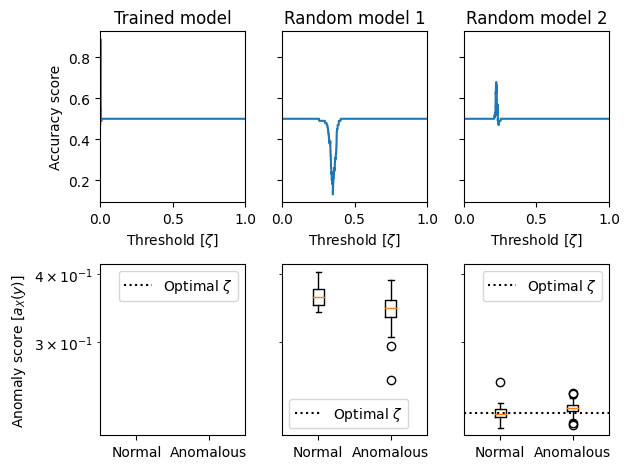

In [ ]:
#zeta_xlims = [(0, 0.001), (0.25, 0.38), (0.25, 0.38)]
zeta_xlims = [(0, 1), (0, 1), (0, 1)]
titles = ["Trained model", "Random model 1", "Random model 2"]
zetas = torch.linspace(
    threshold_tuning_options["zeta_min"],
    threshold_tuning_options["zeta_max"],
    threshold_tuning_options["steps"],
)
fig, axs = plt.subplots(ncols=3, nrows=2, sharey="row")
for i in range(3):
    axs[0, i].plot(zetas, accs_list[i])
    axs[0, i].set_xlim(zeta_xlims[i])
    axs[0, i].set_xlabel("Threshold [$\zeta$]")
    axs[0, i].set_title(titles[i])
    axs[1, i].boxplot(
        [
            scores_list[i][0 : general_options["num_series"]],
            scores_list[i][general_options["num_series"] : -1],
        ],
        labels=["Normal", "Anomalous"],
    )
    axs[1, i].set_yscale("log")
    axs[1, i].axhline(
        zetas[torch.argmax(accs_list[i])], color="k", linestyle=":", label="Optimal $\zeta$"
    )
    axs[1, i].legend()
axs[0, 0].set_ylabel("Accuracy score")
axs[1, 0].set_ylabel("Anomaly score [$a_X(y)$]")
fig.tight_layout()

In [ ]:
@ct.lattice
def testing_workflow(
    opt_params: dict,
    gamma_length: int,
    n_samples: int,
    probs_func: callable,
    best_zetas: list,
    p: int,
    split_data: int,
    X_all: float,
    Y_all: float,
    num_series: int,
    noise_amp: float,
    spike_amp: float,
    max_duration: int,
    t_init: float,
    t_end: float,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    random_model_seeds: torch.Tensor,
    W_layers: int,
) -> list:
    """A workflow for calculating anomaly scores for a set of testing time series
    given an optimal model and set of random models. We use the optimal zetas found in threshold tuning.
    """
    # Generate time series
    X_val_norm, T = generate_normal_time_series_set(split_data, X_all, p, num_series, noise_amp, t_init, t_end)
    X_val_anom, T = generate_anomalous_time_series_set(
        split_data, Y_all, p, num_series, noise_amp, spike_amp, max_duration, t_init, t_end
    )
    truth_labels = get_truth_labels(X_val_norm, X_val_anom)

    # Prepare quantum functions
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits, probs_func)

    accs_list = []
    # Evaluate optimal model
    scores = get_norm_and_anom_scores(
        X_val_norm, X_val_anom, T, callable_proj, opt_params, gamma_length, n_samples
    )
    preds = get_preds_given_threshold(best_zetas[0], scores)
    accs_list.append(get_accuracy_score(preds, truth_labels))
    # Evaluate random models
    for zeta, seed in zip(best_zetas[1:], random_model_seeds):
        rand_params = get_initial_parameters(W, W_layers, n_qubits, seed)
        scores = get_norm_and_anom_scores(
            X_val_norm, X_val_anom, T, callable_proj, rand_params, gamma_length, n_samples
        )
        preds = get_preds_given_threshold(zeta, scores)
        accs_list.append(get_accuracy_score(preds, truth_labels))
    return accs_list

In [ ]:
testing_options = {
    "spike_amp": 0.4,
    "max_duration": 5,
    "split_data": 3, #testing data
    "X_all": X_all,
    "Y_all": Y_all,
    "best_zetas": [zetas[torch.argmax(accs)] for accs in accs_list],
    "random_model_seeds": [0, 1],
    "W_layers": 2,
    "opt_params": results_dict["opt_params"],
}

testing_options.update(general_options)

test_dispatch_id = ct.dispatch(testing_workflow)(**testing_options)
ct_test_results = ct.get_result(dispatch_id=test_dispatch_id, wait=True)
accs_list = ct_test_results.result

In [ ]:
print(accs_list)

[tensor(0.8500, dtype=torch.float32), tensor(0.5000, dtype=torch.float32), tensor(0.6900, dtype=torch.float32)]


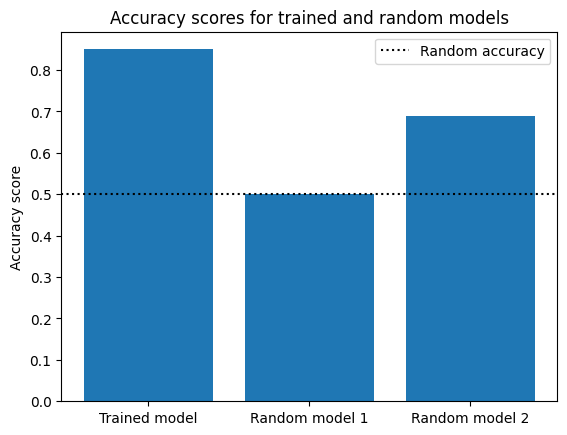

In [ ]:
plt.figure()
plt.bar([1, 2, 3], accs_list)
plt.axhline(0.5, color="k", linestyle=":", label="Random accuracy")
plt.xticks([1, 2, 3], ["Trained model", "Random model 1", "Random model 2"])
plt.ylabel("Accuracy score")
plt.title("Accuracy scores for trained and random models")
leg = plt.legend()

In [ ]:
# Shut down the covalent server
stop = os.system("covalent stop")

In [ ]:
print(accs_list)

[tensor(0.8500, dtype=torch.float32), tensor(0.5000, dtype=torch.float32), tensor(0.6900, dtype=torch.float32)]
